# Traffic Prediction

## Setting up the workspace

In [88]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import numpy as np
from sklearn.metrics import mean_squared_error
import seaborn as sns
from xgboost import XGBRegressor

# Set up the color scheme
background_color = '#1B1B1B'
line_color = '#7DF9FF'
text_color = 'white'

# Load the data
file_path = 'comptages-routiers-permanents.csv'  # Replace with your file path
data = pd.read_csv(file_path, delimiter=';')

In [6]:
data.head()

,Identifiant arc,Libelle,Date et heure de comptage,Débit horaire,Taux d'occupation,Etat trafic,Identifiant noeud amont,Libelle noeud amont,Identifiant noeud aval,Libelle noeud aval,Etat arc,Date debut dispo data,Date fin dispo data,geo_point_2d,geo_shape
0,4264,AV_Champs_Elysees,2023-02-01 22:00:00+00:00,764.0,11.28000,Fluide,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
1,4264,AV_Champs_Elysees,2023-02-01 21:00:00+00:00,819.0,16.52056,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
2,4264,AV_Champs_Elysees,2023-02-01 19:00:00+00:00,1082.0,19.98722,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
3,4264,AV_Champs_Elysees,2023-02-01 17:00:00+00:00,1027.0,23.27334,Pré-saturé,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.87153587897717, 2.3017227924560615","{""coordinates"": [[2.3009951475338766, 48.87177..."
4,4264,AV_Champs_Elysees,2022-12-06 23:00:00+00:00,528.0,68.14334,Bloqué,2294,Av_Champs_Elysees-Washington,2293,Av_Champs_Elysees-Berri,Invalide,2005-01-01,2019-06-01,"48.871535879911605, 2.3017227924560624","{""coordinates"": [[2.300995147533877, 48.871777..."


## Data Analysis

In this section, we are going to plot the data to understand the underlying trends. This will help us in the next steps to make decisions concerning the data.

In [59]:
# Convert 'Date et heure de comptage' to datetime format for analysis
data['Date et heure de comptage'] = pd.to_datetime(data['Date et heure de comptage'], errors='coerce', utc=True)

# Filter data for the two roads
data_champs_elysees = data[data['Libelle'] == 'AV_Champs_Elysees']
data_convention = data[data['Libelle'] == 'Convention']

start_date = '2023-11-25'
end_date = '2023-12-04'
df_filtered = data_champs_elysees[(data_champs_elysees['Date et heure de comptage'] >= start_date) & (data_champs_elysees['Date et heure de comptage'] <= end_date)]

# Prepare data for Traffic Volume Trends
traffic_data_champs_elysees = data_champs_elysees.dropna(subset=['Date et heure de comptage', 'Débit horaire'])
traffic_data_convention = data_convention.dropna(subset=['Date et heure de comptage', 'Débit horaire'])

# Prepare data for Occupancy Rate Trends
occupancy_data_champs_elysees = data_champs_elysees.dropna(subset=['Date et heure de comptage', 'Taux d\'occupation'])
occupancy_data_convention = data_convention.dropna(subset=['Date et heure de comptage', 'Taux d\'occupation'])

# Prepare data for Traffic Condition Distribution
traffic_condition_data_champs_elysees = data_champs_elysees['Etat trafic'].dropna()
traffic_condition_data_convention = data_convention['Etat trafic'].dropna()

Here we created several tables to remove the missing values. 

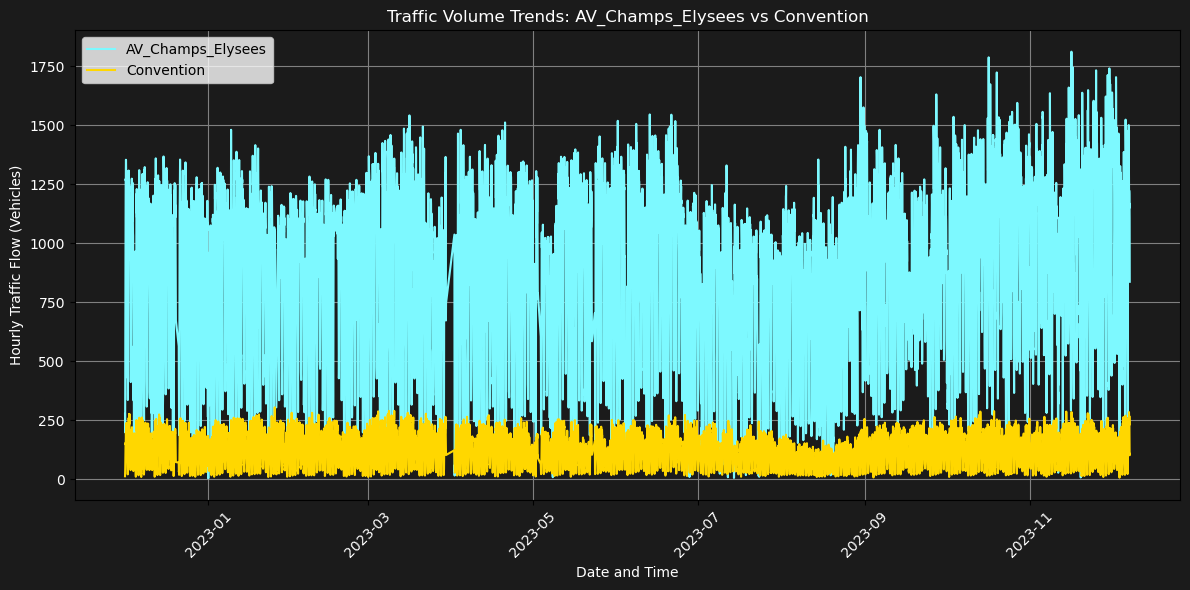

In [17]:
# Plotting Traffic Volume Trends for both roads
plt.figure(figsize=(12, 6), facecolor=background_color)
plt.gca().set_facecolor(background_color)

# AV_Champs_Elysees
sns.lineplot(x='Date et heure de comptage', y='Débit horaire', data=data_champs_elysees, color='#7DF9FF', label='AV_Champs_Elysees')

# Convention
sns.lineplot(x='Date et heure de comptage', y='Débit horaire', data=data_convention, color='#FFD700', label='Convention')

plt.title('Traffic Volume Trends: AV_Champs_Elysees vs Convention', color=text_color)
plt.xlabel('Date and Time', color=text_color)
plt.ylabel('Hourly Traffic Flow (Vehicles)', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.legend()
plt.grid(True, color='grey')
plt.tight_layout()
plt.show()

You can already see that the traffic in the Champs Elysees is more important than in Convention. You can also see that there might be some daily, weekly and yearly trends that we can analyse. We will now group by the data to observe these trends.

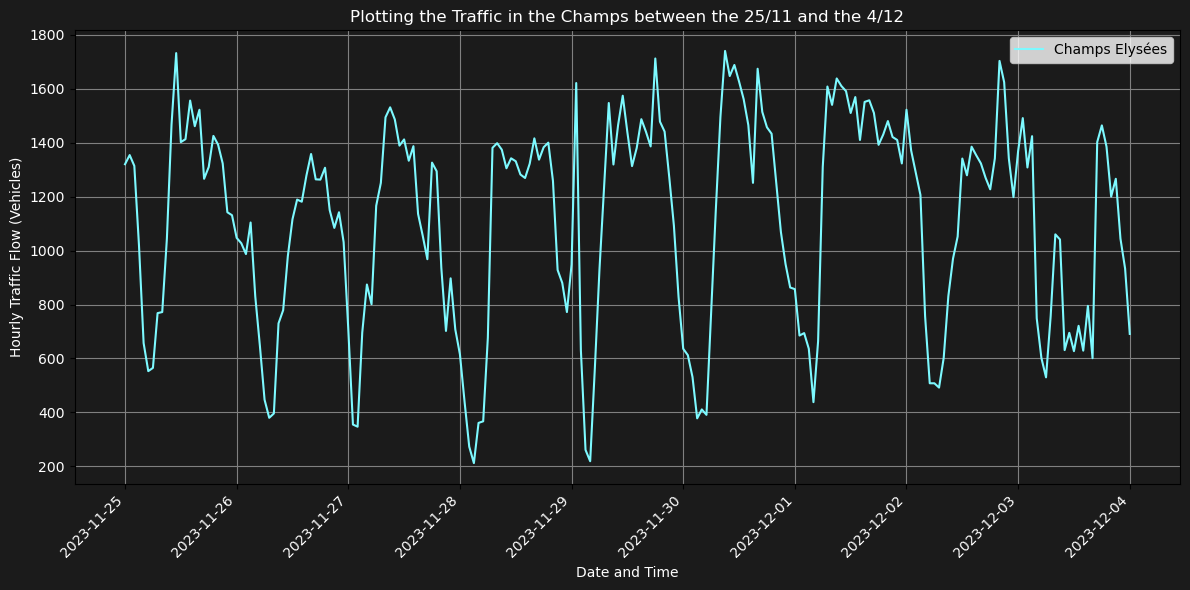

In [15]:
plt.figure(figsize=(12, 6), facecolor=background_color)
ax = plt.gca()
ax.set_facecolor(background_color)
df_filtered.plot(x='Date et heure de comptage', y='Débit horaire', kind='line', label='Champs Elysées', linestyle='-', color='#7DF9FF', ax=ax)
plt.title('Plotting the Traffic in the Champs between the 25/11 and the 4/12', color=text_color)
plt.xlabel('Date and Time', color=text_color)
plt.ylabel('Hourly Traffic Flow (Vehicles)', color=text_color)
plt.xticks(rotation=45, color=text_color)
plt.yticks(color=text_color)
plt.legend()
plt.grid(True, color='grey')
plt.tight_layout()
plt.show()

This graph shows more clearly the daily pattern we can observe for road traffic.

In [18]:
traffic_data_chmps = traffic_data_champs_elysees[['Date et heure de comptage', 'Débit horaire']]
traffic_data_conv = traffic_data_convention[['Date et heure de comptage', 'Débit horaire']]

traffic_data_chmps['Day of Week'] = traffic_data_chmps['Date et heure de comptage'].dt.day_name()
traffic_data_chmps['Hour'] = traffic_data_chmps['Date et heure de comptage'].dt.hour
traffic_data_chmps['Month'] = traffic_data_chmps['Date et heure de comptage'].dt.month_name()

traffic_data_conv['Day of Week'] = traffic_data_conv['Date et heure de comptage'].dt.day_name()
traffic_data_conv['Hour'] = traffic_data_conv['Date et heure de comptage'].dt.hour
traffic_data_conv['Month'] = traffic_data_conv['Date et heure de comptage'].dt.month_name()

# Group data by these new columns
grouped_by_day_chmps = traffic_data_chmps[['Day of Week', 'Débit horaire']].groupby('Day of Week').mean()
grouped_by_hour_chmps = traffic_data_chmps[['Hour', 'Débit horaire']].groupby('Hour').mean()
grouped_by_month_chmps = traffic_data_chmps[['Month', 'Débit horaire']].groupby('Month').mean()
grouped_by_day_conv = traffic_data_conv[['Day of Week', 'Débit horaire']].groupby('Day of Week').mean()
grouped_by_hour_conv = traffic_data_conv[['Hour', 'Débit horaire']].groupby('Hour').mean()
grouped_by_month_conv = traffic_data_conv[['Month', 'Débit horaire']].groupby('Month').mean()


/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/1345408098.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data_chmps['Day of Week'] = traffic_data_chmps['Date et heure de comptage'].dt.day_name()
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/1345408098.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  traffic_data_chmps['Hour'] = traffic_data_chmps['Date et heure de comptage'].dt.hour
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/1345408098.

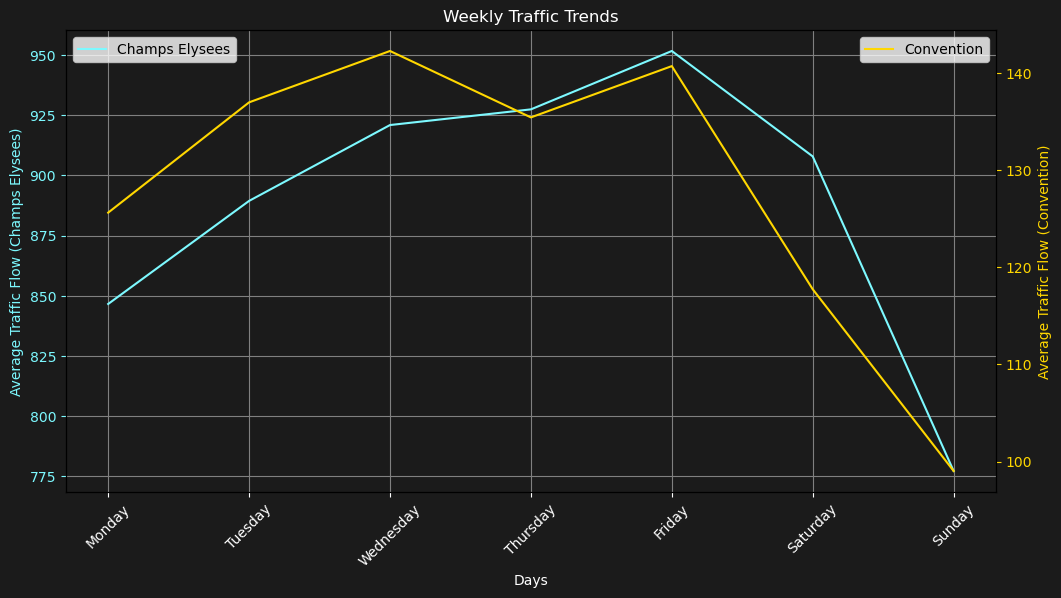

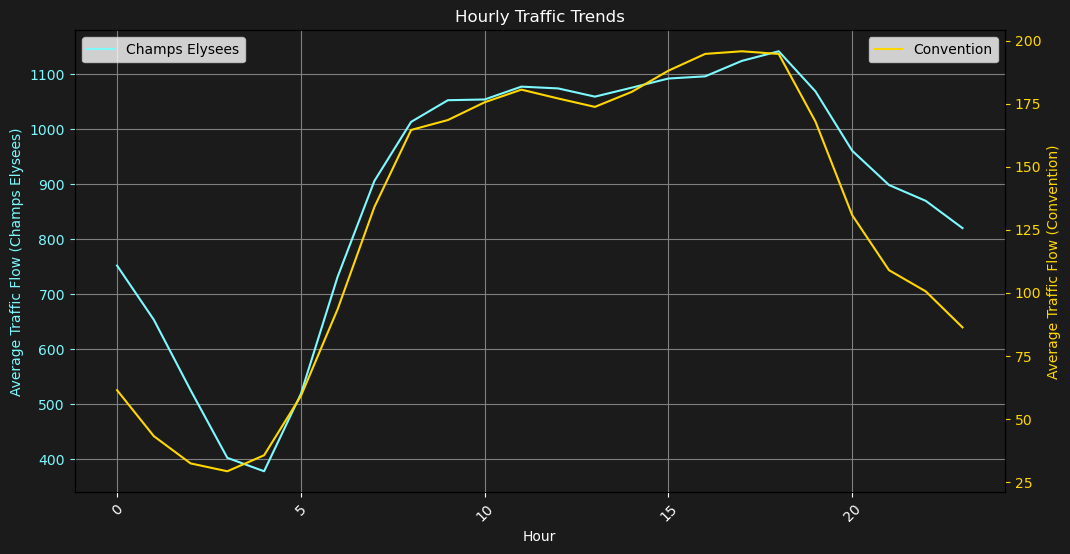

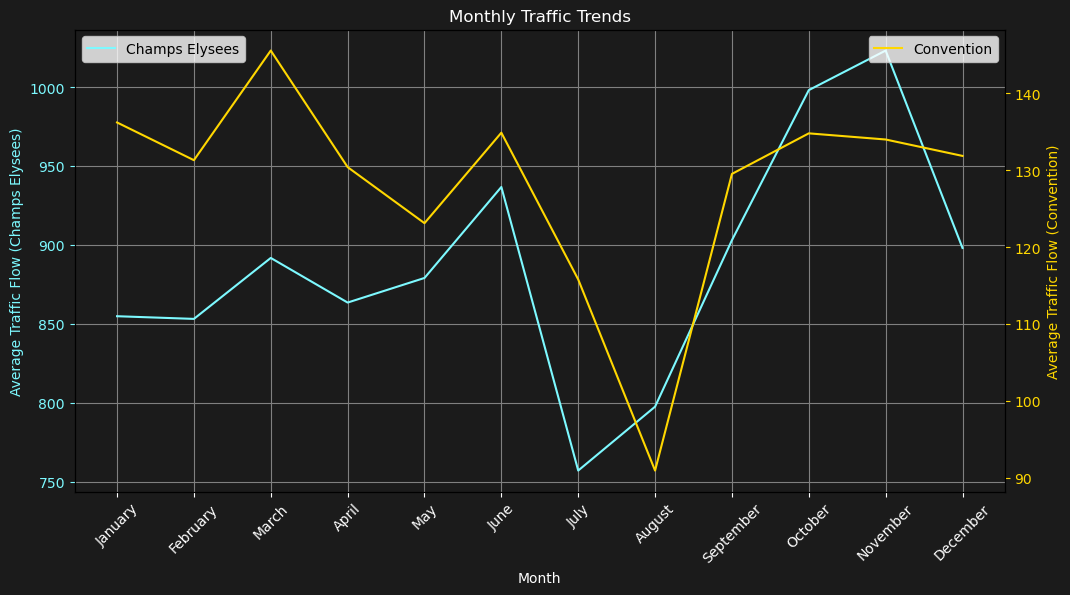

In [20]:
# Sorting based on typical order for days and months
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
months_order = ["January", "February", "March", "April", "May", "June", 
                "July", "August", "September", "October", "November", "December"]
grouped_by_day_chmps = grouped_by_day_chmps.reindex(days_order)
grouped_by_month_chmps = grouped_by_month_chmps.reindex(months_order)
grouped_by_day_conv = grouped_by_day_conv.reindex(days_order)
grouped_by_month_conv = grouped_by_month_conv.reindex(months_order)

# Plotting Daily Trends (Day of Week)
plt.figure(figsize=(12, 6), facecolor=background_color)
ax1 = plt.gca()  # Get current axis
ax1.set_facecolor(background_color)
sns.lineplot(data=grouped_by_day_chmps['Débit horaire'], label='Champs Elysees', color='#7DF9FF', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=grouped_by_day_conv['Débit horaire'], label='Convention', color='#FFD700', ax=ax2)
plt.title('Weekly Traffic Trends', color=text_color)
ax1.set_xlabel('Days', color=text_color)
ax1.set_ylabel('Average Traffic Flow (Champs Elysees)', color='#7DF9FF')
ax2.set_ylabel('Average Traffic Flow (Convention)', color='#FFD700')
ax1.tick_params(axis='x', rotation=45, colors=text_color)
ax1.tick_params(axis='y', colors='#7DF9FF')
ax2.tick_params(axis='y', colors='#FFD700')
ax1.grid(True, color='grey')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plotting Hourly Trends (Hour of Day)
plt.figure(figsize=(12, 6), facecolor=background_color)
ax1 = plt.gca()  # Get current axis
ax1.set_facecolor(background_color)
sns.lineplot(data=grouped_by_hour_chmps['Débit horaire'], label='Champs Elysees', color='#7DF9FF', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=grouped_by_hour_conv['Débit horaire'], label='Convention', color='#FFD700', ax=ax2)
plt.title('Hourly Traffic Trends', color=text_color)
ax1.set_xlabel('Hour', color=text_color)
ax1.set_ylabel('Average Traffic Flow (Champs Elysees)', color='#7DF9FF')
ax2.set_ylabel('Average Traffic Flow (Convention)', color='#FFD700')
ax1.tick_params(axis='x', rotation=45, colors=text_color)
ax1.tick_params(axis='y', colors='#7DF9FF')
ax2.tick_params(axis='y', colors='#FFD700')
ax1.grid(True, color='grey')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Plotting Monthly Trends
plt.figure(figsize=(12, 6), facecolor=background_color)
ax1 = plt.gca()  # Get current axis
ax1.set_facecolor(background_color)
sns.lineplot(data=grouped_by_month_chmps['Débit horaire'], label='Champs Elysees', color='#7DF9FF', ax=ax1)
ax2 = ax1.twinx()
sns.lineplot(data=grouped_by_month_conv['Débit horaire'], label='Convention', color='#FFD700', ax=ax2)
plt.title('Monthly Traffic Trends', color=text_color)
ax1.set_xlabel('Month', color=text_color)
ax1.set_ylabel('Average Traffic Flow (Champs Elysees)', color='#7DF9FF')
ax2.set_ylabel('Average Traffic Flow (Convention)', color='#FFD700')
ax1.tick_params(axis='x', rotation=45, colors=text_color)
ax1.tick_params(axis='y', colors='#7DF9FF')
ax2.tick_params(axis='y', colors='#FFD700')
ax1.grid(True, color='grey')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

The first graph shows that the traffic is more important on week days and it reaches its highest values on Friday for the Champs and Wednesday and Friday for Convention.

The second graph shows the daily trends. You can see that for both streets, the traffic reaches its minimum at 5am and its peak at 5pm.

The third graph shows the yearly trends. You can see that the traffic is higher during winter (probably due to the low temperatures) It reaches a peak in February and November. You can also observe a third peak in June. This is probably due to the travels during the summer holidays.

## Adding External Data

In [60]:
chantiers = pd.read_csv('chantiers-a-paris.csv', delimiter = ';') 
chantiers_pertu = pd.read_csv('chantiers-perturbants.csv', delimiter = ';')
calendar = pd.read_csv('dimdate-QueryResult.csv', delimiter = ',')
vacations = pd.read_csv('fr-en-calendrier-scolaire.csv', delimiter = ';')
weather = pd.read_csv('donnees-synop-essentielles-omm.csv', delimiter = ';')
markets = pd.read_csv('marches-decouverts.csv', delimiter = ';')
events = pd.read_csv('que-faire-a-paris-.csv', delimiter = ';')
touristic_zones = pd.read_csv('zones-touristiques-internationales.csv', delimiter = ';')
weather_forecast = pd.read_csv('weather_forecast.csv', delimiter = ',') 

In [61]:
chantiers = chantiers[['Code postal arrondissement - Commune',
                                   'Date début du chantier', 
                                   'Date fin du chantier',
                                   'Synthèse - Nature du chantier',
                                   'Encombrement espace public',]]

chantiers_pertu = chantiers_pertu[["Code postal de l'arrondissement", 
                                                "Typologie",  
                                                'Objet', 
                                                'Voie(s)',  
                                                'Date de début', 
                                                'Date de fin', 
                                                'Impact sur la circulation', 
                                                'Niveau de perturbation',
                                                'Statut',]]

traffic = data.drop(columns=['geo_point_2d', 'geo_shape', 'Date debut dispo data', 'Date fin dispo data'])

calendar = calendar[['word_date', 
                     'date', 
                     'year', 
                     'quarter', 
                     'month',
                     'yearmonth', 
                     'day_of_month', 
                     'week', 
                     'day_of_week', 
                     'weekday',
                     'month_and_year', 
                     'holiday']]

vacations = vacations[['Description', 
                     'Population', 
                     'Date de début', 
                     'Date de fin',
                     'Académies', 
                     'Zones', 
                     'annee_scolaire']]

weather = weather[[ "Température (°C)", 
                   'Humidité',
                   'Nebulosité totale',
                   'Précipitations dans la dernière heure',
                    "Vitesse du vent moyen 10 mn",
                   "Date",]]#"Pression au niveau mer", 'Variation de pression en 24 heures', "Pression station", 'Précipitations dans les 24 dernières heures', 

markets = markets[["Identifiant marché",
                    'Produit',
                   'Arrondissement', 
                   'Jours de tenue', 
                   'LUNDI', 
                   'MARDI',
                   'MERCREDI', 
                   'JEUDI', 
                   'VENDREDI', 
                   'SAMEDI', 
                   'DIMANCHE', 
                   'Secteur',
                   'Heure début en semaine',
                   'Heure fin en semaine', 
                   'Heure début le samedi', 
                   'Heure fin le samedi',
                   'Heure début le dimanche', 
                   'Heure fin le dimanche']]


events = events[['Date de début',
                 'Date de fin',
                 'Occurrences',
                 'Mots clés',  
                 'Code postal']]

touristic_zones = touristic_zones[['name', 'type', '@timestamp']]

In [62]:
amont = traffic[traffic["Libelle noeud amont"].isin(['Av_Champs_Elysees-Washington', "Convention-Blomet", "Sts_Peres-Voltaire"])]
aval_amont = amont[amont["Libelle noeud aval"].isin(['Av_Champs_Elysees-Berri', "Lecourbe-Convention", "Sts_Peres-Universite"]) ]


aval_amont["timestamp"] = pd.to_datetime(aval_amont["Date et heure de comptage"], utc=True)
aval_amont["timestamp_short"] = aval_amont["timestamp"].dt.strftime('%Y-%m-%dT%H:%M')
aval_amont["date"] = aval_amont["timestamp"].dt.strftime('%Y-%m-%d')

dict_arr = {"AV_Champs_Elysees": 75008, "Sts_Peres": 75007,  "Convention": 75015}
aval_amont["arrondissement"] = aval_amont['Libelle'].apply(lambda x: dict_arr[x])

y = aval_amont[["Débit horaire"	, "Taux d'occupation",]]
X = aval_amont[["timestamp", "Libelle", "Identifiant arc", "arrondissement", "date"]]

### Holidays

In [63]:
calendar["date"] = pd.to_datetime(calendar["word_date"], utc=True)
calendar["date"] = calendar["date"].dt.strftime('%Y-%m-%d')

calendar["holiday"] = calendar["holiday"].apply(lambda x: None if x in ['MLK', 'USPRESIDENTS', 'VICTORIA', 'MEMORIAL',  'CANADA',
       'USINDEPENDENCE','THANKSGIVINGCANADA', 'VETERANS',  'VETERANSUSG'] else x)

calendar["is_holiday"] = calendar["holiday"].isna().apply(lambda x: 1 if x!=True else 0)

vacations["start_date"] = pd.to_datetime(vacations["Date de début"], utc=True)
vacations["start_date"] = vacations["start_date"].dt.strftime('%Y-%m-%d')

vacations["end_date"] = pd.to_datetime(vacations["Date de fin"], utc=True)
vacations["end_date"] = vacations["end_date"].dt.strftime('%Y-%m-%d')

vacations = vacations[["start_date", "end_date"]]

calendar['key'] = 0
vacations['key'] = 0

special_days =calendar.merge(vacations,on='key', how='outer').drop(columns=["key"])
special_days["holiday_period"] =special_days.apply(lambda x: 1 if ((x[1]>=x[-2]) and (x[1]<=x[-1])) else 0, axis=1)

special_days = special_days[["date", "holiday_period", "holiday", "is_holiday"] ]

special_days = special_days.groupby("date").max()

### Roadworks

In [64]:
chantiers["arrondissement"] = chantiers["Code postal arrondissement - Commune"]
chantiers["start_date"] = pd.to_datetime(chantiers["Date début du chantier"], utc=True)
chantiers["start_date"] = chantiers["start_date"].dt.strftime('%Y-%m-%d')

chantiers["end_date"] = pd.to_datetime(chantiers["Date fin du chantier"], utc=True)
chantiers["end_date"] = chantiers["end_date"].dt.strftime('%Y-%m-%d')

chantiers = chantiers[["start_date", "end_date", "arrondissement"]]

calendar['key'] = 0
chantiers['key'] = 0

chantiers1 =calendar.merge(chantiers,on='key', how='outer').drop(columns=["key"])
chantiers1["chantiers1"] =chantiers1.apply(lambda x: 1 if ((x[1]>=x[-3]) and (x[1]<=x[-2])) else 0, axis=1)

chantiers1 = chantiers1[["date", "chantiers1", "arrondissement"] ]
final_chantiers1 = chantiers1.groupby(by =["date", "arrondissement"]).agg({'chantiers1': 'sum'}).reset_index()

In [65]:
chantiers_pertu["arrondissement"] = chantiers_pertu["Code postal de l'arrondissement"]
chantiers_pertu["start_date"] = pd.to_datetime(chantiers_pertu["Date de début"], utc=True)
chantiers_pertu["start_date"] = chantiers_pertu["start_date"].dt.strftime('%Y-%m-%d')

chantiers_pertu["end_date"] = pd.to_datetime(chantiers_pertu["Date de fin"], utc=True)
chantiers_pertu["end_date"] = chantiers_pertu["end_date"].dt.strftime('%Y-%m-%d')

chantiers_pertu = chantiers_pertu[["start_date", "end_date", "arrondissement",  "Niveau de perturbation", "Statut"]]

calendar['key'] = 0
chantiers_pertu['key'] = 0

chantiers_pertu1 =calendar.merge(chantiers_pertu,on='key', how='outer').drop(columns=["key"])
chantiers_pertu1["chantiers_pertu1"] =chantiers_pertu1.apply(lambda x: 1 if ((x[1]>=x[-5]) and (x[1]<=x[-4])) else 0, axis=1)

chantiers_pertu1 = chantiers_pertu1[["date", "chantiers_pertu1", "arrondissement",  "Niveau de perturbation"] ]
chantiers_pertu1["Niveau de perturbation"] = chantiers_pertu1.apply(lambda x: x["Niveau de perturbation"] if x["chantiers_pertu1"]==1 else 0, axis = 1)

In [66]:
final_chantiers_pertu1 = chantiers_pertu1.groupby(by =["date", "arrondissement"]).agg({"chantiers_pertu1": "sum", "Niveau de perturbation": "mean" }).reset_index()

### Weather

In [67]:
weather_df = weather.rename(columns={"Date" : "timestamp",
                            "Nebulosité totale" : "visibility", #"Pression station" : 'atm_pressure',
                             "Vitesse du vent moyen 10 mn" : "wind_speed",
                             "Température (°C)" : "temp", 
                             "Humidité" : 'humidity', 
                             "Précipitations dans la dernière heure" : "rain"})

weather_df["timestamp"] = pd.to_datetime(weather_df["timestamp"], utc=True)

weather_df = weather_df.set_index('timestamp').resample('1H').interpolate().reset_index()

In [68]:
weather_df.columns

Index(['timestamp', 'temp', 'humidity', 'visibility', 'rain', 'wind_speed'], dtype='object')

In [69]:
weather_forecast = weather_forecast[['datetime', 'temp', 'humidity', 'precip',
       'windspeed', 'cloudcover',]].rename(columns={"datetime" : "timestamp",
                            "cloudcover" : "visibility", #"Pression station" : 'atm_pressure',
                             "windspeed" : "wind_speed",
                             "precip" : "rain"})

### Events

In [70]:
events["arrondissement"] = events["Code postal"]
events["start_date"] = pd.to_datetime(events["Date de début"], utc=True)
events["start_date"] = events["start_date"].dt.strftime('%Y-%m-%d')

events["end_date"] = pd.to_datetime(events["Date de fin"], utc=True)
events["end_date"] = events["end_date"].dt.strftime('%Y-%m-%d')

events = events[["start_date", "end_date", "arrondissement"]]
events["event_duration"]=  (pd.to_datetime(events["end_date"] )- pd.to_datetime( events["start_date"])).dt.days +1

events_arr = events[events["arrondissement"].isin(["75007", "75008", "75015"])]

calendar['key'] = 0
events_arr['key'] = 0

events1 =calendar.merge(events_arr,on='key', how='outer').drop(columns=["key"])


/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/3454438259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  events_arr['key'] = 0


In [71]:
events1["events1"] =events1.apply(lambda x: 1 if ((x['date'] >= x['start_date']) and (x['date'] <= x['end_date'])) else 0, axis=1)

In [72]:
events1 = events1[events1['events1']==1]
events1["short_event"] = events1["event_duration"].apply(lambda x: 1 if x < 15 else 0)
events1["long_event"] = events1["event_duration"].apply(lambda x: 1 if x >= 15 else 0)

In [73]:
final_events1 = events1[["date", 'arrondissement','events1', 'short_event', 'long_event']].groupby(by =["date", "arrondissement"]).sum().reset_index()
final_events1["arrondissement"] = final_events1["arrondissement"].astype(int)

### Markets

In [74]:
markets = markets[markets["Arrondissement"].isin([6, 7, 8, 15])]
markets["Arrondissement"] = markets["Arrondissement"]+75000
# markets = markets[['Produit', 'Arrondissement', 'LUNDI', 'MARDI','MERCREDI', 'JEUDI', 'VENDREDI', 'SAMEDI', 'DIMANCHE']]
markets1 = pd.melt(markets, id_vars=['Produit', "Arrondissement"], var_name='Day', value_name='IsEventDay')

# Filter only rows where the event is on that day
markets1 = markets1[markets1['IsEventDay'] == 1]

markets1["Day"] = markets1["Day"].str.lower()

french_day_mapping = {
    'lundi': 1,
    'mardi': 2,
    'mercredi': 3,
    'jeudi': 4,
    'vendredi': 5,
    'samedi': 6,
    'dimanche': 7
}

markets1['Day'] = markets1['Day'].map(french_day_mapping)


In [75]:
# Identify rows where 'samedi' column has value 1
mask = markets['SAMEDI'] == 1

# Create markets2 DataFrame based on identified rows
markets2 = markets.loc[mask, ['Identifiant marché', 'Heure début le samedi', 'Heure fin le samedi', "Arrondissement"]]

markets2['day'] = 6
columns = {"Heure début le samedi": 'heure_debut', 'Heure fin le samedi': 'heure_fin'}
markets2 = markets2.rename(columns=columns)

mask = markets['DIMANCHE'] == 1
markets3 = markets.loc[mask, ['Identifiant marché', 'Heure début le dimanche', 'Heure fin le dimanche', "Arrondissement"]]
markets3['day'] = 7
columns = {"Heure début le dimanche": 'heure_debut', 'Heure fin le dimanche': 'heure_fin'}
markets3 = markets3.rename(columns=columns)

stacked_df = pd.concat([markets2, markets3], ignore_index=True, axis=0)

day_map = {'LUNDI': 1, 'MARDI': 2, 'MERCREDI': 3, 'JEUDI': 4, 'VENDREDI': 5}

# Create an empty DataFrame to store results
markets_result = pd.DataFrame(columns=['Identifiant marché', 'Heure début en semaine', 'Heure fin en semaine', 'day', "Arrondissement"])

# Iterate through each day and filter rows
for day, day_num in day_map.items():
    mask = markets[day] == 1
    day_df = markets.loc[mask, ['Identifiant marché', 'Heure début en semaine', 'Heure fin en semaine', "Arrondissement"]]
    day_df['day'] = day_num
    markets_result = pd.concat([markets_result, day_df])

columns = {"Heure début en semaine": 'heure_debut', 'Heure fin en semaine': 'heure_fin'}
markets_result = markets_result.rename(columns=columns)

stacked_df_1 = pd.concat([stacked_df, markets_result], ignore_index=True, axis=0)

stacked_df_1.rename(columns={'Arrondissement': 'arrondissement'}, inplace=True)
stacked_df_1.rename(columns={'day': 'weekday'}, inplace=True)


In [76]:
markets_final = stacked_df_1.groupby(by = ["arrondissement", "weekday", ]).agg({"Identifiant marché" :"count", "heure_debut" : "max", "heure_fin":"min"})
markets_final.rename(columns={'Identifiant marché': 'number_markets'}, inplace=True)
markets_final.reset_index(inplace=True)

markets_final["starting_hour"] = pd.to_datetime(markets_final["heure_debut"]).dt.hour -2
markets_final["stopping_hour"] =  pd.to_datetime(markets_final["heure_fin"]).dt.hour +2

markets_final.drop(columns = ["heure_debut", "heure_fin"], inplace=True)

/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/2767719341.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  markets_final["starting_hour"] = pd.to_datetime(markets_final["heure_debut"]).dt.hour -2
/var/folders/2f/9dkfxmjx077_hs31d2c5k27w0000gn/T/ipykernel_1521/2767719341.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  markets_final["stopping_hour"] =  pd.to_datetime(markets_final["heure_fin"]).dt.hour +2


### Calendar

In [77]:
calendar_final = calendar[['date', 'year', 'quarter', 'month', 'yearmonth',
       'day_of_month', 'week', 'day_of_week', 'weekday',]]



### Final Merge

In [78]:
traffic_holidays = aval_amont.merge(special_days, on="date", how="left")
traffic_roadworks = traffic_holidays.merge(final_chantiers1, on=["date", "arrondissement"], how="left")
traffic_roadworks2 = traffic_roadworks.merge(final_chantiers_pertu1, on=["date", "arrondissement"], how="left")
traffic_weather = traffic_roadworks2.merge(weather_df, on="timestamp", how="left")

traffic_events = traffic_weather.merge(final_events1, on=["date", "arrondissement"], how="left")

traffic_calendar = traffic_events.merge(calendar_final, on = ["date"], how = "left")

traffic_markets = traffic_calendar.merge(markets_final, on = ["weekday", "arrondissement"], how = "left")

In [79]:
traffic_markets["timestamp_hour"] = traffic_markets["timestamp"].dt.hour
traffic_markets["ongoing_market"] = traffic_markets.apply(lambda x: 1 if x["starting_hour"] <= x["timestamp_hour"] <= x["stopping_hour"] else 0, axis = 1)
traffic_markets["year_day"] = pd.to_datetime(traffic_markets["date"]).dt.dayofyear
columns_to_transform = ["week", "weekday", "year_day", "timestamp_hour"]

trig = {"week": 52, "weekday": 7, "year_day":365, "timestamp_hour":24}

for x in columns_to_transform:
    traffic_markets[("cos_"+x)] = np.cos(2 * np.pi * traffic_markets[x]/trig[x])
    traffic_markets[("sin_"+x)] = np.sin(2 * np.pi * traffic_markets[x]/trig[x])

traffic_final = traffic_markets[['Libelle', 'arrondissement','Débit horaire', "Taux d'occupation", 'timestamp', 'temp', 'humidity', 'rain',
       'wind_speed', 'visibility', 'date', 'holiday_period', 'holiday',
       'is_holiday', 'chantiers1', 'chantiers_pertu1',
       'Niveau de perturbation', 'events1', 'short_event', 'long_event',
       'year', 'quarter', 'month', 'yearmonth', 'day_of_month', 'week',
       'day_of_week', 'weekday', 'number_markets', 'starting_hour',
       'stopping_hour', 'timestamp_hour', 'ongoing_market', 'year_day',
       'cos_week', 'sin_week', 'cos_weekday', 'sin_weekday', 'cos_year_day',
       'sin_year_day', 'cos_timestamp_hour', 'sin_timestamp_hour']].copy()

In [80]:
# Select columns that are not numeric
non_numeric_columns = traffic_final.select_dtypes(exclude=['number']).columns.tolist()

# non_numeric_columns now contains a list of non-numeric column names
print(non_numeric_columns)

['Libelle', 'timestamp', 'date', 'holiday', 'yearmonth', 'day_of_week']


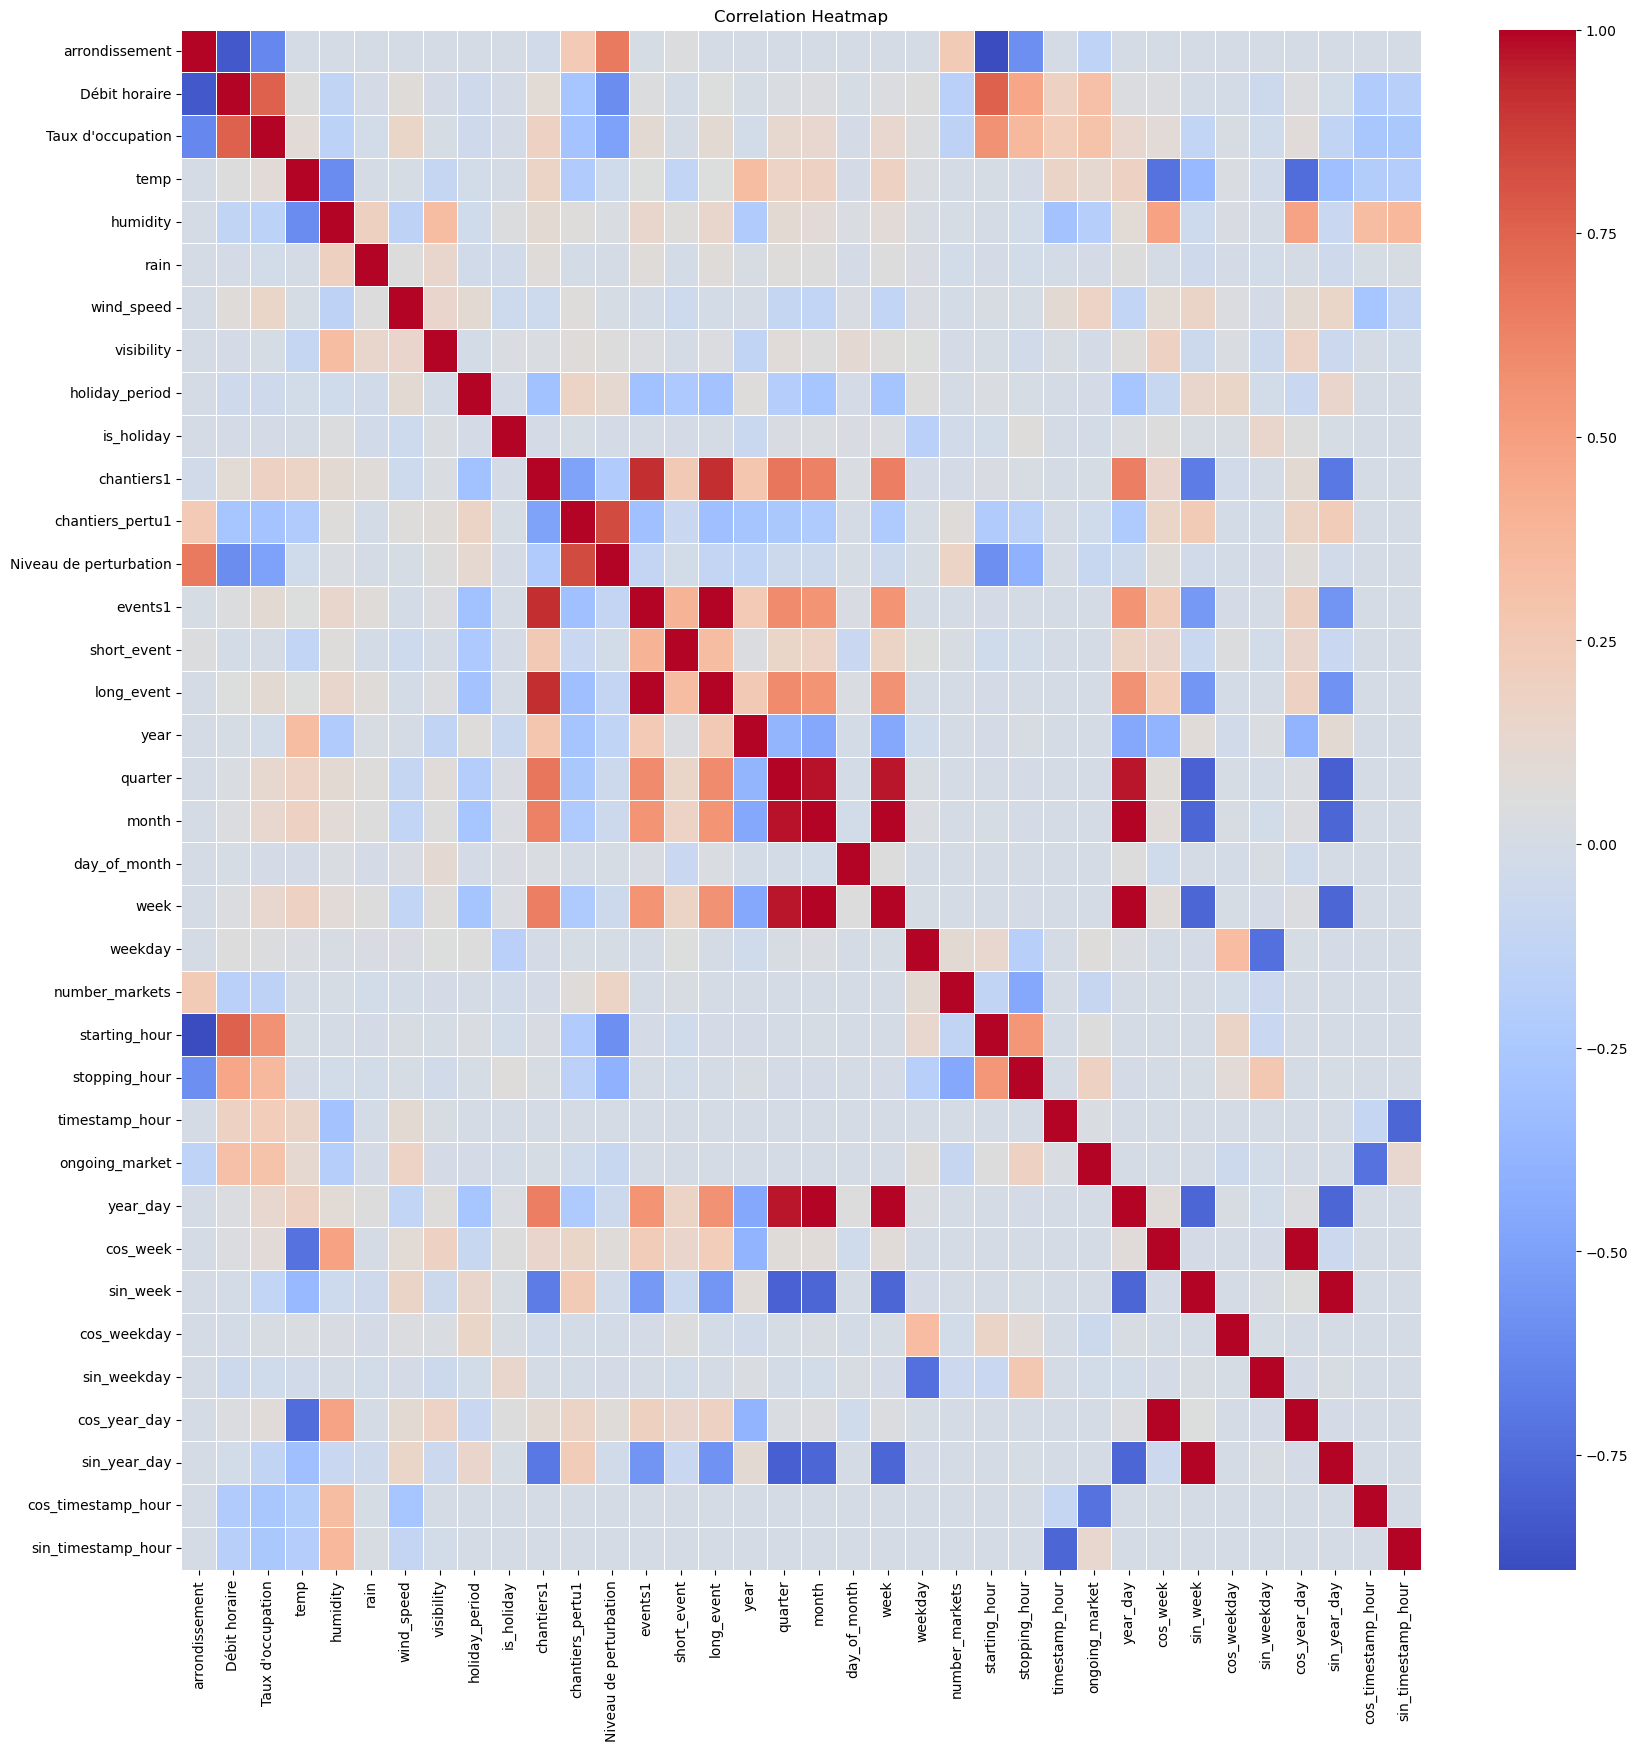

In [81]:
champs_numeric = traffic_final.drop(columns=['Libelle', 'timestamp', 'date', 'holiday', 'yearmonth', 'day_of_week'], errors='ignore')

correlation_matrix = champs_numeric.corr()

# Create a heatmap
plt.figure(figsize=(20,20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Heatmap')
plt.show()

### Modeling

In [84]:
champs = traffic_final[traffic_final['Libelle'] == "AV_Champs_Elysees"].sort_values(by=["timestamp"], ascending=True)
st_peres = traffic_final[traffic_final['Libelle'] == "Sts_Peres"].sort_values(by=["timestamp"], ascending=True)
convention = traffic_final[traffic_final['Libelle'] == "Convention"].sort_values(by=["timestamp"], ascending=True)

In [103]:
def xgboost_forecasting_training(data, n_test, predictor):
    
    train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    
    trainX, trainy = train.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], train.loc[:, [predictor]]
    testX, testy = test.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], test.loc[:, [predictor]]

    
    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    testX = np.asarray(testX)
    testy = np.asarray(testy)

    model = XGBRegressor(objective='reg:squarederror', n_estimators=1000)
    model.fit(trainX, trainy)

    yhat = model.predict(testX)

    error = mean_squared_error(testy, yhat)

    rmse = np.sqrt(error)
    
    return testy, yhat, rmse, model


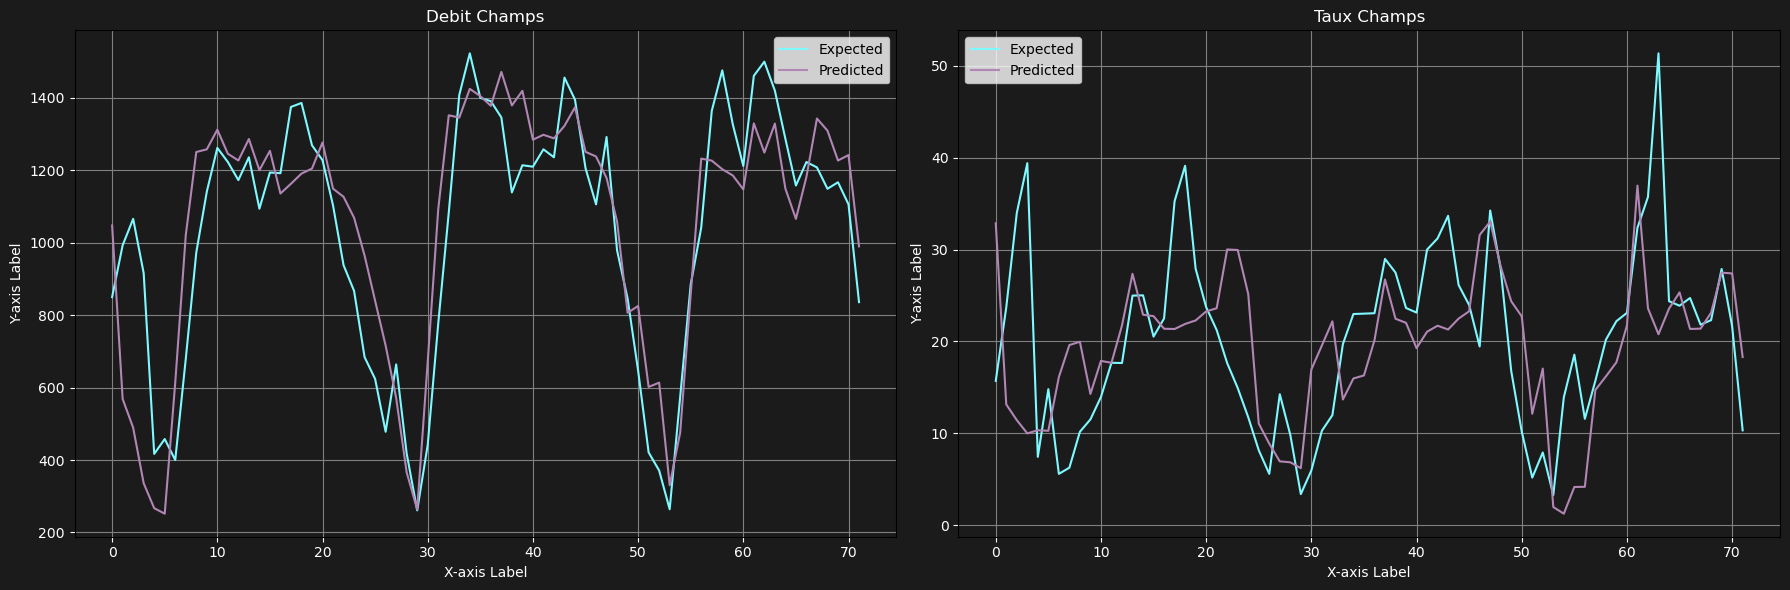

In [104]:
champs_preproc = champs
champs_preproc["temp"] = champs_preproc["temp"].interpolate(method='linear')
champs_preproc["humidity"] = champs_preproc["humidity"].interpolate(method='linear')
champs_preproc["visibility"] = champs_preproc["visibility"].interpolate(method='linear')
champs_preproc["rain"] = champs_preproc["rain"].interpolate(method='linear')
champs_preproc["wind_speed"] = champs_preproc["wind_speed"].interpolate(method='linear')
champs_preproc["Débit horaire"] = champs_preproc["Débit horaire"].interpolate(method='linear')
champs_preproc["Taux d'occupation"] = champs_preproc["Taux d'occupation"].interpolate(method='linear')

champs_preproc = champs_preproc.drop(columns=['Libelle', 'timestamp', 'date', 'holiday', 'yearmonth', 'day_of_week'])

test_champs_y, yhat, rmse_champs_, model = xgboost_forecasting_training(champs_preproc, 72, 'Débit horaire')
test_champs_y2, yhat2, rmse_champs_2, model2 = xgboost_forecasting_training(champs_preproc, 72, "Taux d'occupation")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), facecolor=background_color)

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': test_champs_y, 'yhat': yhat},
    {'testy': test_champs_y2, 'yhat': yhat2}
]

titles = [
    'Debit Champs',
    'Taux Champs'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.set_facecolor(background_color)
    ax.plot(data['testy'], label='Expected', color='#7DF9FF')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()

    # Setting titles, labels, and ticks with specified colors
    ax.set_title(titles[i], color=text_color)
    ax.set_xlabel('X-axis Label', color=text_color)  # Replace 'X-axis Label' with your actual label
    ax.set_ylabel('Y-axis Label', color=text_color)  # Replace 'Y-axis Label' with your actual label
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)

    # Adding grid
    ax.grid(True, color='grey')

plt.tight_layout()
plt.show()

In [105]:
print("The rmse for the debit at the Champs-Elysees is : ", rmse_champs_)
print("The rmse for the taux at the Champs-Elysees is : ", rmse_champs_2)

The rmse for the debit at the Champs-Elysees is :  186.9530497830656
The rmse for the taux at the Champs-Elysees is :  9.45058560965108


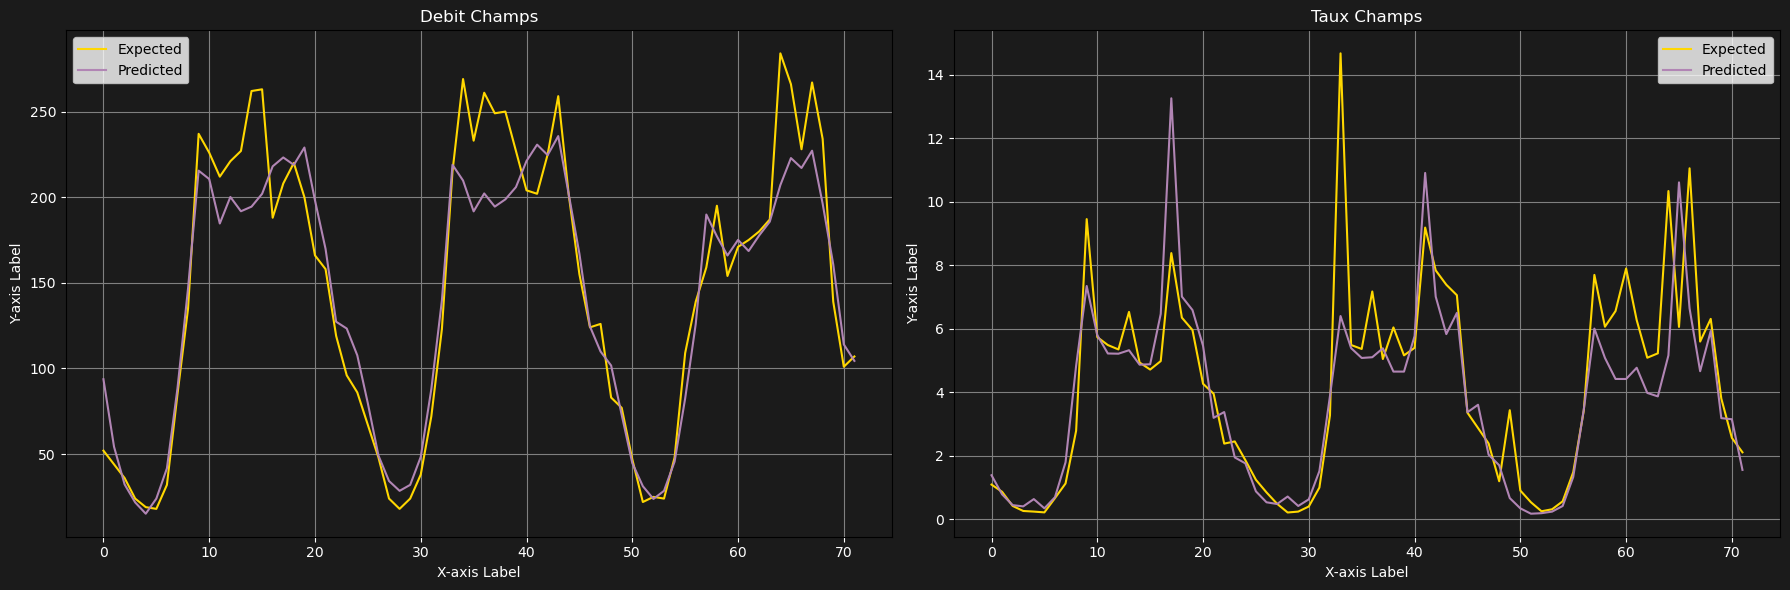

In [100]:
convention_preproc = convention
convention_preproc["temp"] = convention_preproc["temp"].interpolate(method='linear')
convention_preproc["humidity"] = convention_preproc["humidity"].interpolate(method='linear')
convention_preproc["visibility"] = convention_preproc["visibility"].interpolate(method='linear')
convention_preproc["rain"] = convention_preproc["rain"].interpolate(method='linear')
convention_preproc["wind_speed"] = convention_preproc["wind_speed"].interpolate(method='linear')
convention_preproc['Débit horaire'] = convention_preproc['Débit horaire'].interpolate(method='linear')
convention_preproc["Taux d'occupation"] = convention_preproc["Taux d'occupation"].interpolate(method='linear')

convention_preproc = convention_preproc.drop(columns=['Libelle', 'timestamp', 'date', 'holiday', 'yearmonth', 'day_of_week'])

test_conv_y, yhat_conv, rmse_conv_, model = xgboost_forecasting_training(convention_preproc, 72, 'Débit horaire')
test_conv_y2, yhat_conv2, rmse_conv_2, model2 = xgboost_forecasting_training(convention_preproc, 72, "Taux d'occupation")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), facecolor=background_color)

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': test_conv_y, 'yhat': yhat_conv},
    {'testy': test_conv_y2, 'yhat': yhat_conv2}
]

titles = [
    'Debit Champs',
    'Taux Champs'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.set_facecolor(background_color)
    ax.plot(data['testy'], label='Expected', color='#FFD700')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()

    # Setting titles, labels, and ticks with specified colors
    ax.set_title(titles[i], color=text_color)
    ax.set_xlabel('X-axis Label', color=text_color)  # Replace 'X-axis Label' with your actual label
    ax.set_ylabel('Y-axis Label', color=text_color)  # Replace 'Y-axis Label' with your actual label
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)

    # Adding grid
    ax.grid(True, color='grey')

plt.tight_layout()
plt.show()


In [106]:
print("The rmse for the debit at the Champs-Elysees is : ", rmse_conv_)
print("The rmse for the taux at the Champs-Elysees is : ", rmse_conv_2)

The rmse for the debit at the Champs-Elysees is :  26.425522127755386
The rmse for the taux at the Champs-Elysees is :  1.7790665144057178


In [107]:
from sklearn.model_selection import GridSearchCV

def xgboost_forecasting_training(data, n_test, predictor):
    train, test = data.iloc[:-n_test, :], data.iloc[-n_test:, :]
    trainX, trainy = train.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], train.loc[:, [predictor]]
    testX, testy = test.loc[:, ~train.columns.isin(['Débit horaire', "Taux d'occupation"])], test.loc[:, [predictor]]

    trainX = np.asarray(trainX)
    trainy = np.asarray(trainy)
    testX = np.asarray(testX)
    testy = np.asarray(testy)

    # Define the parameter grid to search
    param_grid = {
        'n_estimators': [100, 500, 1000],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5, 7],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'subsample': [0.7, 0.8, 1.0]
    }

    # Initialize the XGBRegressor
    model = XGBRegressor(objective='reg:squarederror')

    # Initialize the GridSearchCV
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, n_jobs=-1, scoring='neg_mean_squared_error')

    # Fit the grid search to the data
    grid_search.fit(trainX, trainy)

    # Best model
    best_model = grid_search.best_estimator_

    # Predict using the best model
    yhat = best_model.predict(testX)

    # Calculate RMSE
    error = mean_squared_error(testy, yhat)
    rmse = np.sqrt(error)

    return testy, yhat, rmse, best_model, grid_search.best_params_


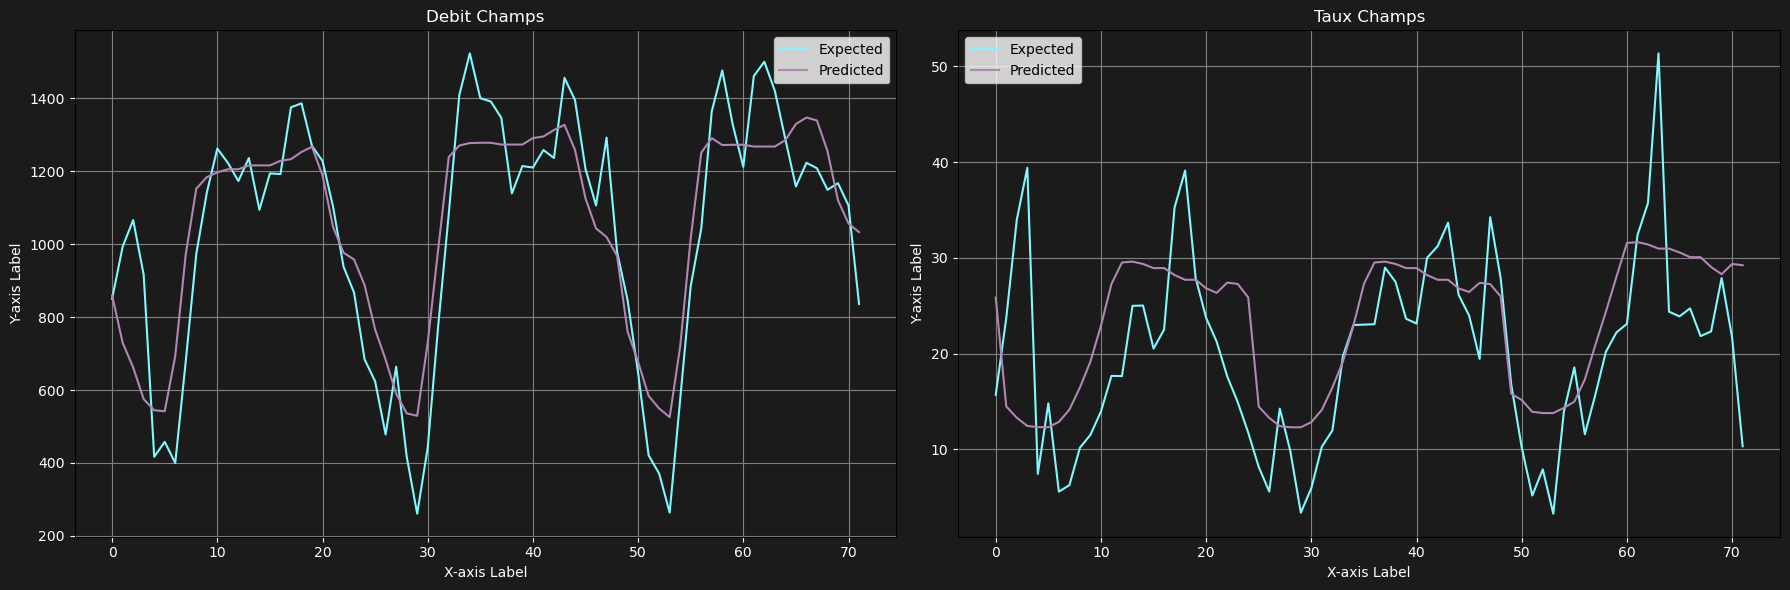

In [109]:
test_champs_y_gs, yhat, rmse_champs_gs, model_gs, params = xgboost_forecasting_training(champs_preproc, 72, 'Débit horaire')
test_champs_y2_gs, yhat2, rmse_champs_2_gs, model2_gs, params2 = xgboost_forecasting_training(champs_preproc, 72, "Taux d'occupation")


fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6), facecolor=background_color)

# Flatten the 2D array of subplots to simplify indexing
axes = axes.flatten()

# Define the data sets (replace these with your actual data)
datasets = [
    {'testy': test_champs_y_gs, 'yhat': yhat},
    {'testy': test_champs_y2_gs, 'yhat': yhat2}
]

titles = [
    'Debit Champs',
    'Taux Champs'
]

# Iterate through each subplot and plot the data
for i, data in enumerate(datasets):
    ax = axes[i]
    ax.set_facecolor(background_color)
    ax.plot(data['testy'], label='Expected', color='#7DF9FF')
    ax.plot(data['yhat'], label='Predicted', color='#b185b4')
    ax.legend()

    # Setting titles, labels, and ticks with specified colors
    ax.set_title(titles[i], color=text_color)
    ax.set_xlabel('X-axis Label', color=text_color)  # Replace 'X-axis Label' with your actual label
    ax.set_ylabel('Y-axis Label', color=text_color)  # Replace 'Y-axis Label' with your actual label
    ax.tick_params(axis='x', colors=text_color)
    ax.tick_params(axis='y', colors=text_color)

    # Adding grid
    ax.grid(True, color='grey')

plt.tight_layout()
plt.show()

In [112]:
print("The rmse for the debit at the Champs-Elysees is : ", rmse_champs_gs)
print("The rmse for the taux at the Champs-Elysees is : ", rmse_champs_2_gs)
print("The best parameters for the debit at the Champs-Elysees is : ", params)
print("The best parameters for the taux at the Champs-Elysees is : ", params)

The rmse for the debit at the Champs-Elysees is :  156.75820235847365
The rmse for the taux at the Champs-Elysees is :  8.168523952895123
The best parameters for the debit at the Champs-Elysees is :  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
The best parameters for the taux at the Champs-Elysees is :  {'colsample_bytree': 0.7, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.7}
